In [59]:
import cv2
import numpy as np
import os, time, glob
from collections import defaultdict, deque
from dataclasses import dataclass
import matplotlib.pyplot as plt
import pandas as pd

In [44]:
current_dir = os.getcwd()
dataset_dir = os.path.join(current_dir, "data")

In [103]:
MATCH_RATIO = 0.75         # Lowe ratio
RANSAC_REPROJ_THR = 3.0    # for geometric check
MIN_TRACK_LEN = 5          # landmark

In [46]:
MAX_FRAMES = None          # None = all frames; or set an int

def load_frames(folder):
    files = []
    files.extend(glob.glob(os.path.join(folder, "*.png")))
    files = sorted(files)
    if MAX_FRAMES: 
        files = files[:MAX_FRAMES]
    imgs = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in files]
    return imgs

imgs = load_frames(dataset_dir)
print(f"Loaded {len(imgs)} frames from {dataset_dir}")

Loaded 200 frames from C:\Users\user\Desktop\classic-vision\data


In [47]:
@dataclass
class DetectionResult:
    key_points: list   # list[cv2.KeyPoint]
    desc: np.ndarray   # descriptor array
    time_ms: float     # keeping that to keep the avg

def detect_sift(img):
    t0 = time.time()
    sift = cv2.SIFT_create()
    key_points, desc = sift.detectAndCompute(img, None)
    dt = (time.time() - t0)*1000
    return DetectionResult(key_points, desc, dt)

def detect_orb(img, nfeatures=2000):
    t0 = time.time()
    orb = cv2.ORB_create(nfeatures=nfeatures)
    key_points, desc = orb.detectAndCompute(img, None)
    dt = (time.time() - t0)*1000
    return DetectionResult(key_points, desc, dt)


def detect_harris_with_orb_descriptors(img, blockSize=2, ksize=3, k=0.04, thresh_rel=0.01, nfeatures_desc=2000):
    t0 = time.time()

    # Harris corner response (score at every pixel)
    h = cv2.cornerHarris(np.float32(img), blockSize, ksize, k) # the corner Strength at every pixel location in the whole image.
                                                               # is a a map of scores.
    # With dilation: A whole small patch around the corner is above the threshold.
    h = cv2.dilate(h, None)

    # Pick pixels with score > (thresh_rel * max score)
    thresh = thresh_rel * h.max()
    ys, xs = np.where(h > thresh)
    if len(xs) == 0:
        return DetectionResult([], None, (time.time() - t0)*1000)

    # Sort by score and keep TOP-N, by nfeatures_desc
    scores = h[ys, xs]
    top_idx = np.argsort(-scores)[:nfeatures_desc]
    xs, ys = xs[top_idx], ys[top_idx]

    # Make keypoints for those positions
    key_points = [cv2.KeyPoint(float(x), float(y), 3) for x, y in zip(xs, ys)]

    # ORB: compute descriptors only (does not detect here)
    orb = cv2.ORB_create()
    key_points, desc = orb.compute(img, key_points)

    dt = (time.time() - t0)*1000
    return DetectionResult(key_points or [], desc, dt)



In [51]:
def bf_match(desc1, desc2, method):
    if desc1 is None or desc2 is None: return []
    if method == "SIFT": norm = cv2.NORM_L2
    else:                norm = cv2.NORM_HAMMING
    bf = cv2.BFMatcher(norm, crossCheck=False)
    try:
        knn = bf.knnMatch(desc1, desc2, k=2)
    except cv2.error:
        return []
    good = []
    for m,n in knn:
        if m.distance < MATCH_RATIO * n.distance:
            good.append(m)
    return good

def geometric_filter(key_points1, key_points2, matches, ransac_thr=RANSAC_REPROJ_THR):
    if len(matches) < 8: return []
    pts1 = np.float32([key_points1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([key_points2[m.trainIdx].pt for m in matches])
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransac_thr)
    mask = mask.ravel().astype(bool) if mask is not None else np.zeros(len(matches), bool)
    return [m for m,ok in zip(matches, mask) if ok]


In [97]:
# This class stores information about a tracked feature across multiple frames
@dataclass
class FeatureTrack:
    track_id: int                  # Unique identifier for this track
    last_frame_index: int          # Last frame index where this track was seen
    consecutive_length: int        # How many consecutive frames it's been matched in
    recent_positions: deque        # Recent (x, y) positions for visualization

In [91]:
def find_features_for_all_pics(detection_method, image_list):
    detection_results = []
    keypoints_per_frame_count = []
    
    for image in image_list:
        result = detection_method(image)
        detection_results.append(result)
        keypoints_per_frame_count.append(len(result.key_points))

    return detection_results, keypoints_per_frame_count

In [95]:
def find_matches_between_consecutive_frames(detection_results, n):
    matches_pics = []
    for frame_index in range(n):
        matches = bf_match(
            detection_results[frame_index].desc,
            detection_results[frame_index + 1].desc,
            method
        )
        matches_geo_filtered = geometric_filter(
            detection_results[frame_index].key_points,
            detection_results[frame_index + 1].key_points,
            matches
        )
        matches_pics.append(matches_geo_filtered)

    return matches_pics

In [99]:
def initialize_tracks_from_first_frame(detection_results, frame_keypoint_to_track, next_track_id):
    """Create a new track for every keypoint in the first frame."""
    all_tracks = {}
    for kp_index, _ in enumerate(detection_results[0].key_points):
        frame_keypoint_to_track[0][kp_index] = next_track_id
        all_tracks[next_track_id] = FeatureTrack(
            track_id=next_track_id,
            last_frame_index=0,
            consecutive_length=1,
            recent_positions=deque(maxlen=MIN_TRACK_LEN)
        )
        position_xy = detection_results[0].key_points[kp_index].pt
        all_tracks[next_track_id].recent_positions.append(position_xy)
        next_track_id += 1
    return all_tracks, next_track_id


In [105]:
def propagate_tracks_forward(
    detection_results,
    matches_between_frames,
    frame_keypoint_to_track,
    all_tracks,
    next_track_id
):
    """Propagate existing tracks forward and start new tracks for unmatched keypoints."""
    for frame_index in range(len(detection_results) - 1):
        current_map = frame_keypoint_to_track[frame_index]
        next_map = frame_keypoint_to_track[frame_index + 1]

        # Update existing tracks
        for match in matches_between_frames[frame_index]:
            prev_kp_index = match.queryIdx
            next_kp_index = match.trainIdx

            if prev_kp_index in current_map:
                track_id = current_map[prev_kp_index]
                next_map[next_kp_index] = track_id
                track_data = all_tracks[track_id]

                if track_data.last_frame_index == frame_index:
                    track_data.consecutive_length += 1
                    track_data.last_frame_index = frame_index + 1
                    track_data.recent_positions.append(
                        detection_results[frame_index + 1].key_points[next_kp_index].pt
                    )

        # Start new tracks for unmatched keypoints
        matched_next_indices = set(next_map.keys())
        for next_kp_index in range(len(detection_results[frame_index + 1].key_points)):
            if next_kp_index not in matched_next_indices:
                frame_keypoint_to_track[frame_index + 1][next_kp_index] = next_track_id
                all_tracks[next_track_id] = FeatureTrack(
                    track_id=next_track_id,
                    last_frame_index=frame_index + 1,
                    consecutive_length=1,
                    recent_positions=deque(maxlen=MIN_TRACK_LEN)
                )
                position_xy = detection_results[frame_index + 1].key_points[next_kp_index].pt
                all_tracks[next_track_id].recent_positions.append(position_xy)
                next_track_id += 1

    return all_tracks, next_track_id


In [107]:
def count_stable_landmarks(all_tracks, min_track_length):
    """Count tracks that meet the stability threshold."""
    return sum(1 for track in all_tracks.values() if track.consecutive_length >= min_track_length)

In [117]:
# def draw_matches(image_a, keypoints_a, image_b, keypoints_b, matches, max_draw=60):
#     matches_to_draw = matches[:max_draw]
#     return cv2.drawMatches(
#         image_a, keypoints_a,
#         image_b, keypoints_b,
#         matches_to_draw, None,
#         flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
#     )

def draw_matches_from_outputs(
    image_list,
    detection_results,
    matches_between_frames,
    frame_index,
    max_draw=60
):
    """
    Draw side-by-side matches for frames frame_index -> frame_index+1
    using only the pipeline outputs.
    """
    img_a = image_list[frame_index]
    img_b = image_list[frame_index + 1]
    kps_a = detection_results[frame_index].key_points
    kps_b = detection_results[frame_index + 1].key_points
    matches = matches_between_frames[frame_index][:max_draw]

    vis = cv2.drawMatches(
        img_a, kps_a,
        img_b, kps_b,
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    return vis


In [119]:
# def run_pipeline(image_list, method="SIFT", visualize_pairs=(10, 11)):
#     # Select the feature detector function
#     if method == "SIFT":
#         detect_features = detect_sift
#     elif method == "ORB":
#         detect_features = detect_orb
#     elif method == "HARRIS":
#         detect_features = detect_harris_with_orb_descriptors
#     else:
#         raise ValueError("method must be SIFT | ORB | HARRIS")

#     # Step 1: detect features in all frames
#     start_time = time.time()
#     detection_results, keypoints_per_frame_count = find_features_for_all_pics(detect_features, image_list)
#     total_runtime_ms = (time.time() - start_time) * 1000.0
    
#     # Step 2: match features between consecutive frames
#     matches_between_frames = find_matches_between_consecutive_frames(detection_results, len(image_list) - 1)

#     # ---- Step 3: Initialize track management structures ----
#     frame_keypoint_to_track = [dict() for _ in range(len(image_list))]
    
#     all_tracks, next_track_id = initialize_tracks_from_first_frame(detection_results, frame_keypoint_to_track, 0)
    
#     all_tracks, next_track_id = propagate_tracks_forward(
#         detection_results,
#         matches_between_frames,
#         frame_keypoint_to_track,
#         all_tracks,
#         next_track_id
#     )
    
#     landmark_count = count_stable_landmarks(all_tracks, MIN_TRACK_LEN)
    
#     metrics = {
#         "method": method,
#         "runtime_ms_total": total_runtime_ms,
#         "runtime_ms_per_frame_avg": np.mean([d.time_ms for d in detection_results]),
#         "avg_candidates_per_frame": float(np.mean(keypoints_per_frame_count)),
#         f"num_landmarks_ge_{MIN_TRACK_LEN}": landmark_count,
#     }
    
#     # Step 7: visualization (optional)
#     if visualize_pairs is not None:
#         frame_a, frame_b = visualize_pairs
#         vis_image = draw_matches(
#             image_list[frame_a], detection_results[frame_a].key_points,
#             image_list[frame_b], detection_results[frame_b].key_points,
#             matches_between_frames[frame_a]
#         )
#     else:
#         vis_image = None
    
#     return metrics, detection_results, matches_between_frames, all_tracks, vis_image

def run_pipeline(image_list, method="SIFT"):
    # Select the feature detector function
    if method == "SIFT":
        detect_features = detect_sift
    elif method == "ORB":
        detect_features = detect_orb
    elif method == "HARRIS":
        detect_features = detect_harris_with_orb_descriptors
    else:
        raise ValueError("method must be SIFT | ORB | HARRIS")

    # Step 1: detect features in all frames
    start_time = time.time()
    detection_results, keypoints_per_frame_count = find_features_for_all_pics(detect_features, image_list)
    total_runtime_ms = (time.time() - start_time) * 1000.0
    
    # Step 2: match features between consecutive frames
    matches_between_frames = find_matches_between_consecutive_frames(detection_results, len(image_list) - 1)

    # ---- Step 3: Initialize track management structures ----
    frame_keypoint_to_track = [dict() for _ in range(len(image_list))]
    
    all_tracks, next_track_id = initialize_tracks_from_first_frame(detection_results, frame_keypoint_to_track, 0)
    
    all_tracks, next_track_id = propagate_tracks_forward(
        detection_results,
        matches_between_frames,
        frame_keypoint_to_track,
        all_tracks,
        next_track_id
    )
    
    landmark_count = count_stable_landmarks(all_tracks, MIN_TRACK_LEN)
    
    metrics = {
        "method": method,
        "runtime_ms_total": total_runtime_ms,
        "runtime_ms_per_frame_avg": np.mean([d.time_ms for d in detection_results]),
        "avg_candidates_per_frame": float(np.mean(keypoints_per_frame_count)),
        f"num_landmarks_ge_{MIN_TRACK_LEN}": landmark_count,
    }
    
    return metrics, detection_results, matches_between_frames, all_tracks

In [133]:
all_results = []

for method in ["SIFT", "ORB", "HARRIS"]:
    print(f"\n=== {method} ===")
    metrics, detection_results, matches_between_frames, all_tracks = run_pipeline(imgs, method=method)
    all_results.append(metrics)
    print(metrics)



=== SIFT ===
{'method': 'SIFT', 'runtime_ms_total': 13756.954431533813, 'runtime_ms_per_frame_avg': 68.76968145370483, 'avg_candidates_per_frame': 2540.5, 'num_landmarks_ge_5': 10410}

=== ORB ===
{'method': 'ORB', 'runtime_ms_total': 1724.2705821990967, 'runtime_ms_per_frame_avg': 8.61636996269226, 'avg_candidates_per_frame': 2000.0, 'num_landmarks_ge_5': 10362}

=== HARRIS ===
{'method': 'HARRIS', 'runtime_ms_total': 2304.2385578155518, 'runtime_ms_per_frame_avg': 11.411103010177612, 'avg_candidates_per_frame': 1868.535, 'num_landmarks_ge_5': 5618}


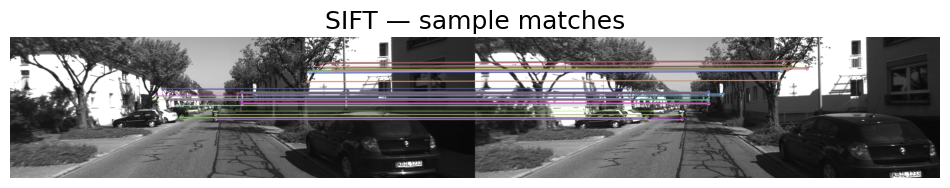

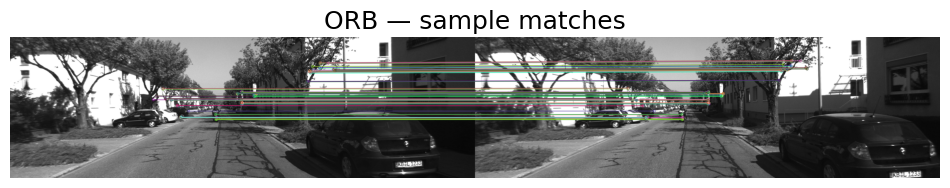

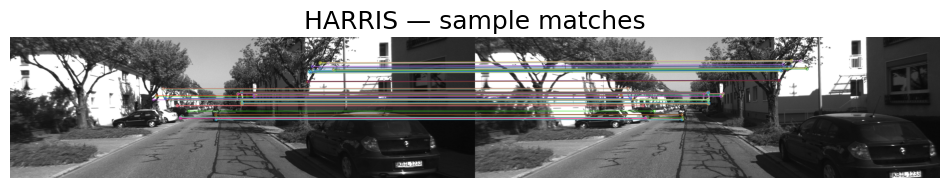

In [135]:
methods = ["SIFT", "ORB", "HARRIS"]
visuals = {m: None for m in methods}

for m in methods:
    visuals[m] = draw_matches_from_outputs(
        imgs, detection_results, matches_between_frames,
        frame_index=3, max_draw=100
    )
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(visuals[m], cv2.COLOR_BGR2RGB))
    plt.title(f"{m} — sample matches", fontsize=18)
    plt.axis('off')
    plt.show()


In [137]:
df = pd.DataFrame(all_results)
df = df[["method","runtime_ms_total","runtime_ms_per_frame_avg",
         "avg_candidates_per_frame", f"num_landmarks_ge_{MIN_TRACK_LEN}"]]
df.style.format({
    "runtime_ms_total": "{:.1f}",
    "runtime_ms_per_frame_avg": "{:.1f}",
    "avg_candidates_per_frame": "{:.0f}"
})


,method,runtime_ms_total,runtime_ms_per_frame_avg,avg_candidates_per_frame,num_landmarks_ge_5
0,SIFT,13757.0,68.8,2540,10410
1,ORB,1724.3,8.6,2000,10362
2,HARRIS,2304.2,11.4,1869,5618


In [71]:
import cv2
import numpy as np

def visualize_matches_overlay(img1, key_points1, img2, key_points2, matches,
                              blend_img2=True, max_draw=800, thickness=1):
    """
    Draw red crosses at features on img1 and green lines/arrows to matched
    points from img2 projected into img1 using a RANSAC homography.
    """
    # ensure BGR
    base = img1.copy()
    if len(base.shape) == 2:
        base = cv2.cvtColor(base, cv2.COLOR_GRAY2BGR)
    overlay = base.copy()

    # ---- compute homography to map img2->img1 (so we can draw in one image)
    if len(matches) >= 8:
        pts1 = np.float32([key_points1[m.queryIdx].pt for m in matches])
        pts2 = np.float32([key_points2[m.trainIdx].pt for m in matches])
        H, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC, 3.0)
        inliers = mask.ravel().astype(bool) if mask is not None else np.zeros(len(matches), bool)
    else:
        H, inliers = None, np.zeros(len(matches), bool)

    # ---- softly blend warped img2 onto img1 for that “both frames in one” look
    if blend_img2 and H is not None:
        h, w = img1.shape[:2]
        if len(img2.shape) == 2:
            img2b = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
        else:
            img2b = img2
        warped = cv2.warpPerspective(img2b, H, (w, h))
        overlay = cv2.addWeighted(overlay, 0.6, warped, 0.4, 0)

    # ---- draw ALL detected key_points on frame-1 as red "×"
    for kp in key_points1:
        p = tuple(map(int, kp.pt))
        cv2.drawMarker(overlay, p, (0,0,255), markerType=cv2.MARKER_TILTED_CROSS,
                       markerSize=8, thickness=1)

    # ---- draw matches as green arrows (only inliers if H exists)
    drawn = 0
    for m, ok in zip(matches, inliers if H is not None else [True]*len(matches)):
        if drawn >= max_draw: break
        if not ok: continue
        p1 = tuple(map(int, key_points1[m.queryIdx].pt))
        p2 = key_points2[m.trainIdx].pt
        if H is not None:
            p2p = cv2.perspectiveTransform(np.array([[p2]], dtype=np.float32), H)[0,0]
            p2 = tuple(map(int, p2p))
        else:
            p2 = tuple(map(int, p2))
        cv2.arrowedLine(overlay, p1, p2, (0,255,0), thickness=thickness, tipLength=0.25)
        cv2.circle(overlay, p2, 2, (0,255,0), -1)
        drawn += 1

    return overlay


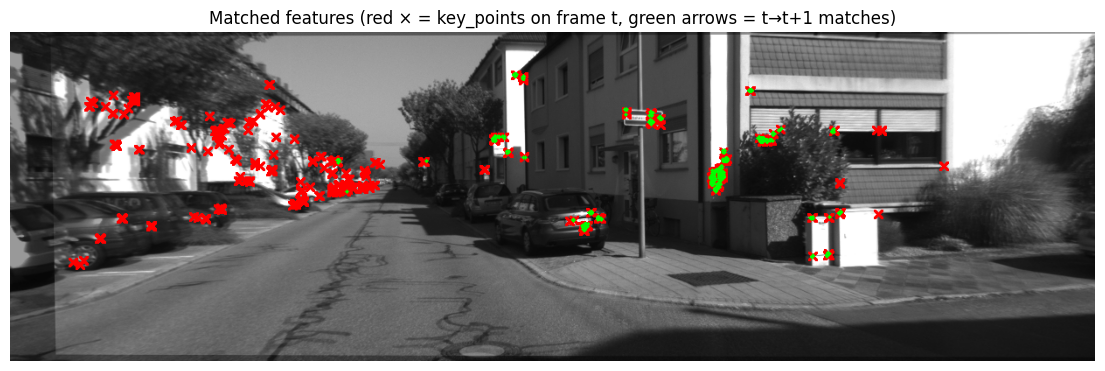

In [81]:
# Example for frames 0→1, method "SIFT"
i = 100
overlay = visualize_matches_overlay(
    imgs[i], dets[i].key_points, imgs[i+1], dets[i+1].key_points, all_matches[i],
    blend_img2=True, max_draw=1200, thickness=1
)

plt.figure(figsize=(14,5))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Matched features (red × = key_points on frame t, green arrows = t→t+1 matches)")
plt.axis("off"); plt.show()


In [31]:
import cv2
import numpy as np

def test_orb_keypoint_size():
    # Method 1: Try to load a sample image (works in many OpenCV installations)
    try:
        # OpenCV sometimes comes with sample images
        img = cv2.imread('img2.png', 0)  # Try common test image
        if img is None:
            raise FileNotFoundError
    except:
        # Method 2: Create a realistic synthetic image with complex patterns
        print("Creating synthetic image with complex patterns...")
        img = np.zeros((200, 200), dtype=np.uint8)
        
        # Add noise as base texture
        noise = np.random.normal(128, 30, (200, 200))
        img = np.clip(noise, 0, 255).astype(np.uint8)
        
        # Add various geometric patterns at different scales
        # Fine lines
        for i in range(0, 200, 3):
            img[i:i+1, :] = 255
            
        # Medium squares
        for i in range(20, 180, 25):
            for j in range(20, 180, 25):
                img[i:i+8, j:j+8] = 50
                
        # Large circles
        centers = [(50, 50), (150, 50), (100, 150)]
        for cx, cy in centers:
            cv2.circle(img, (cx, cy), 20, 200, 2)
            
        # Add some edges and corners
        cv2.rectangle(img, (80, 80), (120, 120), 100, 3)
        
        # Add gradient
        for i in range(200):
            img[150:170, i] = int(128 + 100 * np.sin(i * 0.1))
    
    print(f"Image shape: {img.shape}")
    print(f"Image dtype: {img.dtype}")
    print(f"Pixel value range: {img.min()} - {img.max()}")
    
    # Choose a point with rich texture (center of image)
    center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
    
    # Show local patch around the test point
    patch_size = 40
    y1 = max(0, center_y - patch_size//2)
    y2 = min(img.shape[0], center_y + patch_size//2)
    x1 = max(0, center_x - patch_size//2)
    x2 = min(img.shape[1], center_x + patch_size//2)
    patch = img[y1:y2, x1:x2]
    
    print(f"\nLocal patch statistics around test point ({center_x}, {center_y}):")
    print(f"Patch std dev: {np.std(patch):.2f}")
    print(f"Patch mean: {np.mean(patch):.2f}")
    print(f"Patch size: {patch.shape}")
    
    # Test different keypoint sizes
    sizes_to_test = [3, 9, 15, 31]
    descriptors = {}
    
    orb = cv2.ORB_create()
    
    for size in sizes_to_test:
        kp = cv2.KeyPoint(float(center_x), float(center_y), float(size))
        _, desc = orb.compute(img, [kp])
        
        if desc is not None:
            descriptors[size] = desc[0]
            print(f"\nSize {size:2d}: {desc[0][:10]} ... (std: {np.std(desc[0]):.2f})")
        else:
            print(f"\nSize {size:2d}: No descriptor computed!")
    
    # Compare descriptors pairwise
    print("\n--- Pairwise Hamming Distances ---")
    sizes = list(descriptors.keys())
    for i, size1 in enumerate(sizes):
        for j, size2 in enumerate(sizes):
            if i < j:  # Only upper triangle
                dist = cv2.norm(descriptors[size1], descriptors[size2], cv2.NORM_HAMMING)
                print(f"Size {size1:2d} vs Size {size2:2d}: {dist:3.0f}/256 bits different ({dist/256*100:.1f}%)")
    
    # Test multiple points to see if it's location-dependent
    print("\n--- Testing Multiple Locations ---")
    test_points = [
        (50, 50),   # Upper left area
        (150, 50),  # Upper right area  
        (100, 150), # Lower center
        (center_x, center_y)  # Center
    ]
    
    for x, y in test_points:
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            kp_small = cv2.KeyPoint(float(x), float(y), 3.0)
            kp_large = cv2.KeyPoint(float(x), float(y), 31.0)
            
            _, desc_small = orb.compute(img, [kp_small])
            _, desc_large = orb.compute(img, [kp_large])
            
            if desc_small is not None and desc_large is not None:
                dist = cv2.norm(desc_small, desc_large, cv2.NORM_HAMMING)
                local_patch = img[max(0,y-10):min(img.shape[0],y+10), 
                                max(0,x-10):min(img.shape[1],x+10)]
                patch_std = np.std(local_patch)
                print(f"Point ({x:3d},{y:3d}): {dist:3.0f} bits diff, local texture std: {patch_std:.1f}")

test_orb_keypoint_size()

Image shape: (1795, 1202)
Image dtype: uint8
Pixel value range: 0 - 254

Local patch statistics around test point (601, 897):
Patch std dev: 9.12
Patch mean: 98.45
Patch size: (40, 40)

Size  3: [177  13  94 188  30 194  64 110 192 208] ... (std: 71.77)

Size  9: [177  13  94 188  30 194  64 110 192 208] ... (std: 71.77)

Size 15: [177  13  94 188  30 194  64 110 192 208] ... (std: 71.77)

Size 31: [177  13  94 188  30 194  64 110 192 208] ... (std: 71.77)

--- Pairwise Hamming Distances ---
Size  3 vs Size  9:   0/256 bits different (0.0%)
Size  3 vs Size 15:   0/256 bits different (0.0%)
Size  3 vs Size 31:   0/256 bits different (0.0%)
Size  9 vs Size 15:   0/256 bits different (0.0%)
Size  9 vs Size 31:   0/256 bits different (0.0%)
Size 15 vs Size 31:   0/256 bits different (0.0%)

--- Testing Multiple Locations ---
Point ( 50, 50):   0 bits diff, local texture std: 9.1
Point (150, 50):   0 bits diff, local texture std: 9.6
Point (100,150):   0 bits diff, local texture std: 9.8
Po